In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

# LangSmith 추적을 설정합니다. https://smith.langchain.com
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("KWATER-GPT")


LangSmith 추적을 시작합니다.
[프로젝트명]
KWATER-GPT


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector as mariadb

from langchain_teddynote.models import get_model_name, LLMs
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

from langchain.agents import create_sql_agent
from langchain.tools import StructuredTool
from langchain_experimental.tools import PythonAstREPLTool


from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import load_prompt
from langchain_core.prompts import ChatPromptTemplate



from typing import List

%load_ext autoreload
%autoreload 2


/Users/iminhyeong/opt/anaconda3/envs/llm_venv/lib/python3.11/site-packages/langchain_experimental/tools/__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_experimental.tools.python.tool import PythonAstREPLTool, PythonREPLTool
/Users/iminhyeong/opt/anaconda3/envs/llm_venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:777: UserWarning: Mixing V1 models and V2 models (or constructs, like `TypeAdapter`) is not supported. Please upgrade `PythonREPL` to V2.
  war

In [3]:
# 최신 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4o)
print(MODEL_NAME)

gpt-4o


# DB Research Team

In [4]:
from agent_config import AgentConfig
from data import DBManager

In [5]:
conf = AgentConfig(
    location_code="A",
    plant_code="SN",
    algorithm_code="C"
)
dbm = DBManager(conf)
db = dbm.get_db_connection()


## 테이블 선택
- 자연어 쿼리를 통해 조회해야 할 테이블 선택

In [6]:
from prompts import Prompt
prompt = Prompt()

# 1. 사용 가능한 테이블 정의
AVAILABLE_TABLES = {
    "TB_C_RT": "실시간 측정 데이터 테이블. 센서의 실시간 측정값을 저장합니다.",
    "TB_AI_C_RT": "AI 분석 결과 테이블. AI가 분석한 예측값과 결과를 저장합니다.",
    "TB_AI_C_CTR": "AI 제어 결과 테이블. AI의 제어 명령과 결과를 저장합니다.",
    "TB_TAG_MNG": "태그 관리 테이블. 시스템에서 사용하는 태그(센서 등)의 메타데이터를 저장합니다."
}

# 2. 테이블 선택 프롬프트 템플릿 작성
table_selection_prompt = prompt.table_selection_prompt()


# 3. 출력 파서 - 테이블 이름 추출 함수
def extract_tables(llm_response: str) -> List[str]:
    """LLM 응답에서 테이블 이름 목록을 추출합니다."""
    tables = []
    for line in llm_response.split('\n'):
        if line.startswith("테이블:"):
            # 대괄호 안의 내용 추출
            content = line.replace("테이블:", "").strip()
            # 쉼표로 구분된 항목을 분리
            if '[' in content and ']' in content:
                content = content.replace('[', '').replace(']', '')
            
            tables = [table.strip() for table in content.split(',')]
            break
    
    # 유효한 테이블만 필터링
    valid_tables = [table for table in tables if table in AVAILABLE_TABLES]
    valid_tables.append("TB_TAG_MNG") if "TB_TAG_MNG" not in valid_tables else None
    return valid_tables


llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

select_table_chain = table_selection_prompt | llm | StrOutputParser()


In [17]:

question = "3월 10일부터 3월 11일까지 AI 약품 기본 주입률을 알려줘"

response = select_table_chain.invoke({"question": question})
selected_tables = extract_tables(response)

print(selected_tables)



['TB_AI_C_RT', 'TB_TAG_MNG']


## SQL 쿼리 생성

In [18]:
TABLE_SCHEMAS = {
    table: db.get_table_info([table]) for table in selected_tables
}

prompt = Prompt()
sql_query_gen_prompt = prompt.sql_query_gen_prompt(TABLE_SCHEMAS)
sql_query_gen_chain = sql_query_gen_prompt | llm | StrOutputParser()

In [19]:
query = sql_query_gen_chain.invoke({"question": question})

print(query)

SELECT UPD_TI, AI_C_RST
FROM TB_AI_C_RT
WHERE UPD_TI BETWEEN '2025-03-10 00:00:00' AND '2025-03-11 23:59:59'
ORDER BY UPD_TI DESC;


## SQL 실행

### STR 형태로 저장

In [20]:
db = dbm.get_db_connection()
result = db.run(query)

result

'[(datetime.datetime(2025, 3, 11, 23, 59), \'{"AI_C_RST": {"STG_3": {"SER_1": "14.91;1G-41131-101-SWI-C403", "SER_2": "15.78;1G-41131-101-SWI-C407"}, "STG_4": {"SER_1": "15.54;1G-41131-101-SWI-C413", "SER_2": "15.63;1G-41131-101-SWI-C417"}}}\'), (datetime.datetime(2025, 3, 11, 23, 54), \'{"AI_C_RST": {"STG_3": {"SER_1": "14.85;1G-41131-101-SWI-C403", "SER_2": "15.78;1G-41131-101-SWI-C407"}, "STG_4": {"SER_1": "15.54;1G-41131-101-SWI-C413", "SER_2": "15.62;1G-41131-101-SWI-C417"}}}\'), (datetime.datetime(2025, 3, 11, 23, 48), \'{"AI_C_RST": {"STG_3": {"SER_1": "14.42;1G-41131-101-SWI-C403", "SER_2": "15.8;1G-41131-101-SWI-C407"}, "STG_4": {"SER_1": "15.57;1G-41131-101-SWI-C413", "SER_2": "15.65;1G-41131-101-SWI-C417"}}}\'), (datetime.datetime(2025, 3, 11, 23, 43), \'{"AI_C_RST": {"STG_3": {"SER_1": "13.44;1G-41131-101-SWI-C403", "SER_2": "15.77;1G-41131-101-SWI-C407"}, "STG_4": {"SER_1": "15.53;1G-41131-101-SWI-C413", "SER_2": "15.61;1G-41131-101-SWI-C417"}}}\'), (datetime.datetime(2025

### DF 형태로 저장

In [21]:
from utils import process_ai_rt

In [22]:
result_df = dbm.select_from_table(query)
ai_rt = result_df.set_index("UPD_TI")
multi_columns = pd.MultiIndex(levels=[[], [], [], [], []], codes=[[], [], [], [], []], names=['ITM', 'STG', 'SER', 'LOC', 'STP'])
df = pd.DataFrame(columns = multi_columns, index = ai_rt.index)

for col in ai_rt.columns:
    for idx in ai_rt.index:
        for path, val in process_ai_rt(ai_rt.at[idx, col]):
            df.at[idx, path] = val

In [23]:
df

ITM                 AI_C_RST                     
STG                        3             4       
SER                        1      2      1      2
LOC                        0      0      0      0
STP                        0      0      0      0
UPD_TI                                           
2025-03-11 23:59:00    14.91  15.78  15.54  15.63
2025-03-11 23:54:00    14.85  15.78  15.54  15.62
2025-03-11 23:48:00    14.42  15.80  15.57  15.65
2025-03-11 23:43:00    13.44  15.77  15.53  15.61
2025-03-11 23:38:00    14.57  15.71  15.47  15.55
...                      ...    ...    ...    ...
2025-03-10 00:22:00    14.42  15.70  15.43  15.51
2025-03-10 00:17:00    14.48  15.72  15.46  15.54
2025-03-10 00:12:00    14.43  15.67  15.40  15.48
2025-03-10 00:07:00    14.43  15.69  15.42  15.50
2025-03-10 00:02:00    14.44  15.70  15.43  15.51

[576 rows x 4 columns]

## 결과 생성

In [24]:


python_repl = PythonAstREPLTool(
        globals={"pd": pd, "plt": plt, "np": np, "sns": sns, "df": df.copy()},  # 필요한 모듈들을 globals에 추가
        locals=None
        # locals={"df": dataframe}  # 데이터프레임을 locals에 추가
    )

In [25]:
agent = create_pandas_dataframe_agent(
        llm,
        result_df,
        verbose=False,
        agent_type="tool-calling",
        allow_dangerous_code=True,
        extra_tools=[python_repl],
        prefix="You are a professional data analyst and expert in Pandas. "
        "You must use Pandas DataFrame(`df`) to answer user's request. "
        "\n\n[IMPORTANT] DO NOT create or overwrite the `df` variable in your code. \n\n"
        "You don't need to generate visualization code."
        "But if you are willing to generate visualization code, please use `plt.show()` at the end of your code. "
        "I prefer seaborn code for visualization, but you can use matplotlib as well."
        "\n\n<Visualization Preference>\n"
        "- [IMPORTANT] Use `English` for your visualization title and labels."
        "The language of final answer should be written in Korean. "
        "\n\n###\n\n<Column Guidelines>\n"
        "If user asks with columns that are not listed in `df.columns`, you may refer to the most similar columns listed below.\n"
    )

In [28]:
answer = agent.invoke({"input":"3단계 1계열 약품 주입률의 평균을 시간대별로 알려줘"})

In [29]:
print(answer['output'])

Agent stopped due to max iterations.


In [8]:
# 3. 출력 파서 - 테이블 이름 추출 함수
def extract_tables(llm_response: str) -> List[str]:
    """LLM 응답에서 테이블 이름 목록을 추출합니다."""

     # 1. 사용 가능한 테이블 정의
    AVAILABLE_TABLES = {
        "TB_C_RT": "실시간 측정 데이터 테이블. 센서의 실시간 측정값을 저장합니다.",
        "TB_AI_C_RT": "AI 분석 결과 테이블. AI가 분석한 예측값과 결과를 저장합니다.",
        "TB_AI_C_CTR": "AI 제어 결과 테이블. AI의 제어 명령과 결과를 저장합니다.",
        "TB_TAG_MNG": "태그 관리 테이블. 시스템에서 사용하는 태그(센서 등)의 메타데이터를 저장합니다."
    }
    
    tables = []
    for line in llm_response.split('\n'):
        if line.startswith("테이블:"):
            # 대괄호 안의 내용 추출
            content = line.replace("테이블:", "").strip()
            # 쉼표로 구분된 항목을 분리
            if '[' in content and ']' in content:
                content = content.replace('[', '').replace(']', '')
            
            tables = [table.strip() for table in content.split(',')]
            break
    
    # 유효한 테이블만 필터링
    valid_tables = [table for table in tables if table in AVAILABLE_TABLES]
    valid_tables.append("TB_TAG_MNG") if "TB_TAG_MNG" not in valid_tables else None
    return valid_tables


def db_research_agent(question: str):
    """
    DB 연구 에이전트
    """
    from prompts import Prompt
    prompt = Prompt()

 

    # 2. 테이블 선택 프롬프트 템플릿 작성
    table_selection_prompt = prompt.table_selection_prompt()
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

    select_table_chain = table_selection_prompt | llm | StrOutputParser()

    response = select_table_chain.invoke({"question": question})
    selected_tables = extract_tables(response)
    
    TABLE_SCHEMAS = {
        table: db.get_table_info([table]) for table in selected_tables
    }

    prompt = Prompt()
    sql_query_gen_prompt = prompt.sql_query_gen_prompt(TABLE_SCHEMAS)
    sql_query_gen_chain = sql_query_gen_prompt | llm | StrOutputParser()

    query = sql_query_gen_chain.invoke({"question": question})

    print(query)

    result_df = dbm.select_from_table(query)

    python_repl = PythonAstREPLTool(
            globals={"pd": pd, "plt": plt, "np": np, "sns": sns, "df": result_df.copy()},  # 필요한 모듈들을 globals에 추가
            locals=None
            # locals={"df": dataframe}  # 데이터프레임을 locals에 추가
        )
    
    agent = create_pandas_dataframe_agent(
            llm,
            result_df,
            verbose=False,
            agent_type="tool-calling",
            allow_dangerous_code=True,
            extra_tools=[python_repl],
            prefix="You are a professional data analyst and expert in Pandas. "
            "You must use Pandas DataFrame(`df`) to answer user's request. "
            "\n\n[IMPORTANT] DO NOT create or overwrite the `df` variable in your code. \n\n"
            "You don't need to generate visualization code."
            "But if you are willing to generate visualization code, please use `plt.show()` at the end of your code. "
            "I prefer seaborn code for visualization, but you can use matplotlib as well."
            "\n\n<Visualization Preference>\n"
            "- [IMPORTANT] Use `English` for your visualization title and labels."
            "The language of final answer should be written in Korean. "
            "\n\n###\n\n<Column Guidelines>\n"
            "If user asks with columns that are not listed in `df.columns`, you may refer to the most similar columns listed below.\n"
        )

    return agent.invoke({"input":question})

In [11]:
question = "3월 10일 원수 탁도의 시간대별 평균을 알려줘"

answer = db_research_agent(question)

print(answer['output'])

SELECT DATE_FORMAT(UPD_TI, '%Y-%m-%d %H:00:00') AS hour, AVG(CAST(TAG_VAL AS DECIMAL(10, 2))) AS average_turbidity
FROM TB_C_RT
WHERE TAG_SN IN (
    SELECT SUBSTRING_INDEX(SUBSTRING_INDEX(TB_TAG_MNG.TAG_SN, '.', 2), '.', -1)
    FROM TB_TAG_MNG
    WHERE AI_CD = 'C' AND DP LIKE '%원수 탁도%' AND TAG_SN NOT LIKE '%AOS%'
)
AND DATE(UPD_TI) = '2025-03-10'
GROUP BY hour
ORDER BY hour;


<string>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


2025년 3월 10일의 시간대별 원수 탁도의 평균은 다음과 같습니다:

- 00:00: 3.5009
- 01:00: 3.5652
- 02:00: 3.6308
- 03:00: 3.5183
- 04:00: 3.4667
- 05:00: 3.5748
- 06:00: 3.7042
- 07:00: 3.7372
- 08:00: 3.7487
- 09:00: 3.7367
- 10:00: 3.6909
- 11:00: 3.6577
- 12:00: 3.6571
- 13:00: 3.7638
- 14:00: 3.7342
- 15:00: 3.7272
- 16:00: 3.7546
- 17:00: 3.7819
- 18:00: 3.8246
- 19:00: 3.7435
- 20:00: 3.7213
- 21:00: 4.0274
- 22:00: 3.9778
- 23:00: 3.8104

이 시간대별 평균을 통해 하루 동안의 탁도 변화를 확인할 수 있습니다.


In [23]:
question = "3월 13일 이전 하루 동안 원수 탁도의 최댓값, 최솟값 등 통계량을 알려줘"

answer = db_research_agent(question)

print(answer['output'])

SELECT MAX(CAST(TAG_VAL AS DECIMAL(10, 2))) AS max_value, MIN(CAST(TAG_VAL AS DECIMAL(10, 2))) AS min_value, AVG(CAST(TAG_VAL AS DECIMAL(10, 2))) AS avg_value
FROM TB_C_RT
WHERE TAG_SN IN (
    SELECT SUBSTRING_INDEX(SUBSTRING_INDEX(TB_TAG_MNG.TAG_SN, '.', 2), '.', -1)
    FROM TB_TAG_MNG
    WHERE AI_CD = 'C' AND DP LIKE '%원수 탁도%' AND TAG_SN NOT LIKE '%AOS%'
)
AND UPD_TI >= '2025-03-12 00:00:00' AND UPD_TI < '2025-03-13 00:00:00';
데이터프레임에 있는 원수 탁도의 통계량은 다음과 같습니다:

- 최댓값: 4.46
- 최솟값: 3.45
- 평균값: 4.118733

이 통계량은 3월 13일 이전 하루 동안의 데이터에 해당합니다.


SELECT DATE_FORMAT(UPD_TI, '%Y-%m-%d %H:00:00') AS hour, AVG(CAST(TAG_VAL AS DECIMAL(10, 2))) AS average_turbidity
FROM TB_C_RT
WHERE TAG_SN IN (
    SELECT SUBSTRING_INDEX(SUBSTRING_INDEX(TB_TAG_MNG.TAG_SN, '.', 2), '.', -1)
    FROM TB_TAG_MNG
    WHERE AI_CD = 'C' AND DP LIKE '%원수 탁도%' AND TAG_SN NOT LIKE '%AOS%'
)
AND UPD_TI >= '2025-03-12 00:00:00' AND UPD_TI < '2025-03-13 00:00:00'
GROUP BY hour
ORDER BY hour;


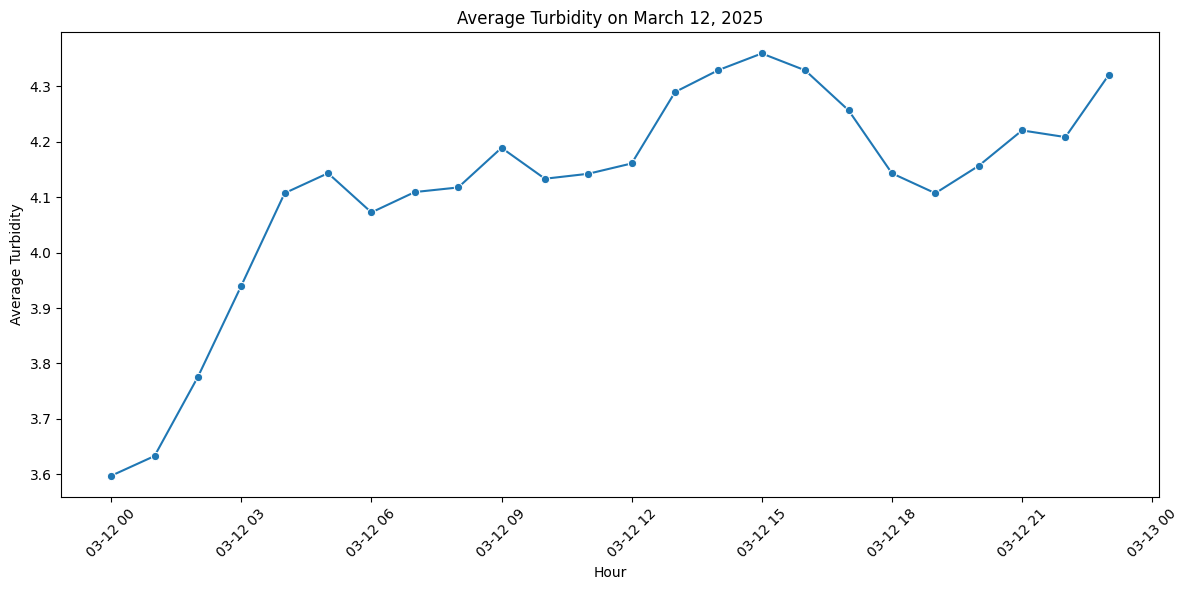

2025년 3월 12일 하루 동안의 시간대별 평균 원수 탁도는 다음과 같습니다:

- 00:00: 3.597
- 01:00: 3.633
- 02:00: 3.776
- 03:00: 3.940
- 04:00: 4.107
- 05:00: 4.143
- 06:00: 4.072
- 07:00: 4.109
- 08:00: 4.117
- 09:00: 4.189
- 10:00: 4.133
- 11:00: 4.142
- 12:00: 4.161
- 13:00: 4.290
- 14:00: 4.329
- 15:00: 4.359
- 16:00: 4.329
- 17:00: 4.257
- 18:00: 4.143
- 19:00: 4.107
- 20:00: 4.156
- 21:00: 4.220
- 22:00: 4.208
- 23:00: 4.321

위의 데이터는 그래프로도 시각화하였습니다. 3월 12일의 시간대별 평균 탁도의 변화를 확인할 수 있습니다.


In [22]:
question = "3월 13일 이전 하루 동안 원수 탁도의 평균을 시간대 별로 확인하고 싶어. 그래프도 그려줘"

answer = db_research_agent(question)

print(answer['output'])

In [125]:

# 4. 테이블 선택 체인 구성
def create_table_selector(model_name="gpt-4o-mini"):
    """테이블 선택 체인을 생성합니다."""
    llm = ChatOpenAI(model=model_name, temperature=0)
    
    # 기본 체인: 프롬프트 -> LLM -> 문자열 출력
    basic_chain = table_selection_prompt | llm | StrOutputParser()
    
    # 테이블 선택 함수
    def select_tables(question: str) -> dict:
        """
        질문을 분석하여 관련 테이블을 선택합니다.
        
        Args:
            question: 사용자 질문
            
        Returns:
            dict: 선택된 테이블 목록과 전체 응답 포함
        """
        # 체인 실행
        response = basic_chain.invoke({"question": question})
        
        # 테이블 추출
        selected_tables = extract_tables(response)
        
        return {
            "selected_tables": selected_tables,
            "full_response": response
        }
    
    return select_tables

# 5. 실행 예시
table_selector = create_table_selector()

# 테스트
def test_table_selection():
    test_questions = [
        "최근 5분 동안의 온도 센서 데이터를 보여줘",
        "AI가 분석한 최근 예측 결과는 어떻게 되나요?",
        "태그 ID가 TEMP001인 센서의 정보를 알려주세요",
        "AI가 어제 내린 제어 명령과 그 결과를 보고싶어요"
    ]
    
    for question in test_questions:
        result = table_selector(question)
        print(f"질문: {question}")
        print(f"선택된 테이블: {result['selected_tables']}")
        print(f"전체 응답:\n{result['full_response']}")
        print("-" * 50)

# 테스트 실행
test_table_selection()

질문: 최근 5분 동안의 온도 센서 데이터를 보여줘
선택된 테이블: ['TB_C_RT', 'TB_TAG_MNG']
전체 응답:
테이블: [TB_C_RT]
이유: 온도 센서의 실시간 측정값을 저장하는 테이블이므로, 최근 5분 동안의 온도 센서 데이터를 조회하기 위해 TB_C_RT 테이블을 선택했습니다.
--------------------------------------------------
질문: AI가 분석한 최근 예측 결과는 어떻게 되나요?
선택된 테이블: ['TB_AI_C_RT', 'TB_TAG_MNG']
전체 응답:
테이블: [TB_AI_C_RT]
이유: AI가 분석한 최근 예측 결과는 AI 분석 결과 테이블인 TB_AI_C_RT에서 확인할 수 있습니다. 이 테이블에는 AI의 예측값과 분석 결과가 저장되어 있으므로, 최근 예측 결과를 조회하기 위해 이 테이블을 선택했습니다.
--------------------------------------------------
질문: 태그 ID가 TEMP001인 센서의 정보를 알려주세요
선택된 테이블: ['TB_TAG_MNG']
전체 응답:
테이블: [TB_TAG_MNG]
이유: 태그 ID가 TEMP001인 센서의 정보는 메타데이터가 저장된 TB_TAG_MNG 테이블에서 조회할 수 있습니다. 이 테이블은 센서와 관련된 태그 정보를 관리하고 있기 때문입니다.
--------------------------------------------------
질문: AI가 어제 내린 제어 명령과 그 결과를 보고싶어요
선택된 테이블: ['TB_AI_C_CTR', 'TB_TAG_MNG']
전체 응답:
테이블: [TB_AI_C_CTR]
이유: AI가 내린 제어 명령과 그 결과는 TB_AI_C_CTR 테이블에 저장되어 있습니다. 이 테이블을 조회하면 어제의 제어 명령과 그에 대한 결과를 확인할 수 있습니다.
--------------------------------------------------


In [126]:
SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model=MODEL_NAME))

SQLDatabaseToolkit(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x14c079a10>, llm=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x14bdc5f50>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x14bdc48d0>, root_client=<openai.OpenAI object at 0x14c1b0510>, root_async_client=<openai.AsyncOpenAI object at 0x14be89150>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********')))

In [127]:
[tool for tool in SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model=MODEL_NAME)).get_tools() if not tool.name == "sql_db_list_tables"]

[QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x14c079a10>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x14c079a10>),
 QuerySQLCheckerTool(description='Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!', 

In [128]:


tools = toolkit.get_tools()
tools



NameError: name 'toolkit' is not defined

['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker']

In [19]:
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")

list_tables_tool.invoke({'table_names': '_C_'})

'TB_AI_B_ALM, TB_AI_B_CTR, TB_AI_B_CTR_BACKUP_20240403, TB_AI_B_CTR_DESC, TB_AI_B_INIT, TB_AI_B_INIT_20240223, TB_AI_B_INIT_BACKUP_20240313, TB_AI_B_RT, TB_AI_B_RT_BACKUP_20240327, TB_AI_B_RT_HMI, TB_AI_C_ALM, TB_AI_C_ALM_BACKUP_20240425, TB_AI_C_CTR, TB_AI_C_CTR_BACKUP_20240327, TB_AI_C_CTR_DESC, TB_AI_C_INIT, TB_AI_C_INIT_BACKUP_20240327, TB_AI_C_INIT_BACKUP_240304, TB_AI_C_INIT_BACKUP_240710, TB_AI_C_INIT_BACKUP_240718, TB_AI_C_RT, TB_AI_C_RT_BACKUP_20240327, TB_AI_C_RT_BACKUP_240304, TB_AI_C_RT_HMI, TB_AI_EMS_INIT, TB_AI_EMS_INIT_BACKUP_240304, TB_AI_EMS_RT, TB_AI_EMS_RT_BACKUP_20240403, TB_AI_EMS_RT_BACKUP_240304, TB_AI_F_ALM, TB_AI_F_CTR_DESC, TB_AI_F_INIT, TB_AI_F_INIT_BACKUP_240304, TB_AI_F_RT, TB_AI_F_RT_BACKUP_240304, TB_AI_F_RT_HMI, TB_AI_I_ALM, TB_AI_I_CTR, TB_AI_I_CTR_DESC, TB_AI_I_INIT, TB_AI_I_INIT_BACKUP_240304, TB_AI_I_RT, TB_AI_I_RT_BACKUP_240304, TB_AI_I_RT_HMI, TB_AI_PK_ALM, TB_AI_PK_CTR, TB_AI_PK_INIT, TB_AI_PK_INIT_BACKUP_20240313, TB_AI_PK_INIT_BACKUP_240304, TB_

In [21]:
list_tables = ["TB_C_RT", "TB_AI_C_RT", "TB_AI_C_CTR", "TB_TAG_MNG"]

get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")



# Query 실행 도구
@tool
def db_query_tool(query: str) -> str:
    """
    Run SQL queries against a database and return results
    Returns an error message if the query is incorrect
    If an error is returned, rewrite the query, check, and retry
    """
    # 쿼리 실행
    result = db.run_no_throw(query)

    # 오류: 결과가 없으면 오류 메시지 반환
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    # 정상: 쿼리 실행 결과 반환
    return result

In [52]:
from langchain_core.prompts import ChatPromptTemplate

# SQL 쿼리의 일반적인 실수를 점검하기 위한 시스템 메시지 정의
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

IMPORTANT: Also check for basic syntax errors such as:
- Incorrect SQL keywords (e.g., 'LIMITS' should be 'LIMIT', 'GROUPP BY' should be 'GROUP BY')
- Missing or extra commas
- Unclosed quotation marks or parentheses
- Invalid table or column references

If there are any mistakes, respond with the corrected query ONLY.
If there are no mistakes, reproduce the original query EXACTLY.

DO NOT execute the query directly. Just return the corrected or original query as text.
"""

# 프롬프트 생성
query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)

# Query Checker 체인 생성
query_check = query_check_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0
).bind_tools([db_query_tool], tool_choice="db_query_tool")

In [59]:
from typing import Annotated, Literal
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain.tools import Tool
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver

from tools import create_tool_node_with_fallback

# 에이전트의 상태 정의
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# 미리 정의된 테이블 목록
TABLES = ["TB_C_RT", "TB_AI_C_RT", "TB_AI_C_CTR", "TB_TAG_MNG"]

# 테이블 목록을 반환하는 함수
def get_tables():
    return "Available tables: " + ", ".join(TABLES)

# 테이블 목록 도구 생성
list_tables_tool = Tool(
    name="sql_db_list_tables",
    func=get_tables,
    description="Lists all tables in the database"
)

# 쿼리 검사 함수
def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """쿼리를 실행하기 전에 정확성 검사"""
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}

# 워크플로우 그래프 생성
workflow = StateGraph(State)

# 노드 추가
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)

# 스키마 선택 모델 노드
model_get_schema = ChatOpenAI(model=MODEL_NAME, temperature=0).bind_tools(
    [get_schema_tool]
)

workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke({"messages": state["messages"]})]
    }
)

# 최종 답변 제출 도구
class SubmitFinalAnswer(BaseModel):
    """쿼리 결과를 기반으로 사용자에게 최종 답변 제출"""
    final_answer: str = Field(..., description="The final answer to the user")

# 쿼리 생성 프롬프트 및 모델
QUERY_GEN_INSTRUCTION = """You are a SQL expert with a strong attention to detail.
...
"""

query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", QUERY_GEN_INSTRUCTION), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | ChatOpenAI(model=MODEL_NAME, temperature=0).bind_tools(
    [SubmitFinalAnswer, model_check_query]
)

# 조건부 분기 함수
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    
    if last_message.content.startswith("Answer:"):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"

# 쿼리 생성 노드
def query_gen_node(state: State):
    message = query_gen.invoke(state)
    
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}...",
                        tool_call_id=tc["id"],
                    )
                )
                
    return {"messages": [message] + tool_messages}

# 노드 추가
workflow.add_node("query_gen", query_gen_node)
workflow.add_node("correct_query", model_check_query)
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# 엣지 설정
workflow.add_edge(START, "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges("query_gen", should_continue)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# 워크플로우 컴파일
app = workflow.compile(checkpointer=MemorySaver())


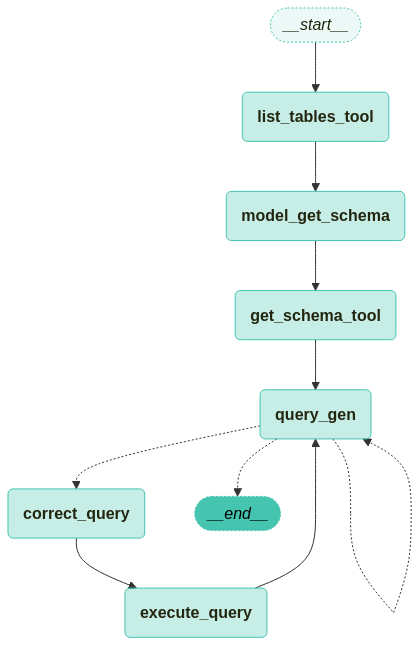

In [60]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)

In [64]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph, stream_graph
from langchain_core.messages import HumanMessage
from langgraph.errors import GraphRecursionError


def run_graph(
    message: str, recursive_limit: int = 30, node_names=[], stream: bool = False
):
    # config 설정(재귀 최대 횟수, thread_id)
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random_uuid()}
    )

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    try:
        if stream:
            # 그래프 실행
            stream_graph(app, inputs, config, node_names=node_names)
        else:
            invoke_graph(app, inputs, config, node_names=node_names)
        output = app.get_state(config).values
        return output
    except GraphRecursionError as recursion_error:
        print(f"GraphRecursionError: {recursion_error}")
        output = app.get_state(config).values
        return output

In [65]:
output = run_graph(
    "AI_RT 테이블에서 최근 값 조회해줘",
    stream=False,
)

ValueError: Last message is not an AIMessage

In [55]:
response = query_check.invoke({"messages": [("user", "SELECT COUNT(*) FROM TB_C_RT GROUPP BY UPD_TI LIMIT 3;")]})

In [56]:
response.tool_calls

[{'name': 'db_query_tool',
  'args': {'query': 'SELECT COUNT(*) FROM TB_C_RT GROUP BY UPD_TI LIMIT 3;'},
  'id': 'call_jQxCCIwZbXoUL8itZvRbZwkG',
  'type': 'tool_call'}]

In [ ]:
from langchain.agents import create_openai_functions_agent, AgentExecutor
from langchain_openai import ChatOpenAI

def create_sql_agent(llm, tools, **kwargs):
    """
    Explantion about the SQL Agent
    """
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    
    agent = create_openai_functions_agent(llm, tools, **kwargs)

    return AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=True)

In [ ]:
# nl_to_sql_tool.py
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from typing import Dict, List, Optional
import pandas as pd

class NLToSQLTool:
    def __init__(self, db_manager, model_name="gpt-4o"):
        self.db_manager = db_manager
        self.llm = ChatOpenAI(model=model_name, temperature=0)
        
    def get_schema_info(self) -> str:
        """데이터베이스 스키마 정보를 문자열로 반환합니다."""
        tables = self.db_manager.get_tables()
        schema_info = []
        
        for table in tables:
            schema_df = self.db_manager.get_table_schema(table)
            columns_info = []
            
            for _, row in schema_df.iterrows():
                column_name = row['COLUMN_NAME']
                data_type = row['DATA_TYPE']
                is_nullable = row['IS_NULLABLE']
                comment = row.get('COLUMN_COMMENT', '')
                
                column_info = f"{column_name} ({data_type}, {'NULL' if is_nullable == 'YES' else 'NOT NULL'})"
                if comment:
                    column_info += f" - {comment}"
                    
                columns_info.append(column_info)
                
            table_info = f"Table: {table}\nColumns:\n" + "\n".join([f"- {col}" for col in columns_info])
            schema_info.append(table_info)
            
        return "\n\n".join(schema_info)
    
    def natural_language_to_sql(self, query: str) -> str:
        """자연어 쿼리를 SQL 쿼리로 변환합니다."""
        schema_info = self.get_schema_info()
        
        prompt = ChatPromptTemplate.from_messages([
            ("system", """
            당신은 자연어를 SQL 쿼리로 변환하는 전문가입니다. 
            사용자의 질문을 분석하여 적절한 SQL 쿼리를 생성해주세요.
            
            다음은 데이터베이스 스키마 정보입니다:
            
            {schema_info}
            
            다음 규칙을 따라주세요:
            1. 항상 유효한 SQL 쿼리만 생성하세요.
            2. 복잡한 질문은 여러 개의 쿼리로 나눌 수 있습니다.
            3. 쿼리 결과를 제한하려면 LIMIT 절을 사용하세요.
            4. 주석은 사용하지 마세요.
            5. 오직 SQL 쿼리만 반환하세요. 다른 설명은 포함하지 마세요.
            """),
            ("human", "{query}")
        ])
        
        response = self.llm.invoke(
            prompt.format(schema_info=schema_info, query=query)
        )
        
        # SQL 쿼리 추출
        sql_query = response.content.strip()
        
        # SQL 키워드로 시작하는지 확인
        sql_keywords = ["SELECT", "WITH", "SHOW", "DESCRIBE", "EXPLAIN"]
        if not any(sql_query.upper().startswith(keyword) for keyword in sql_keywords):
            sql_query = f"SELECT * FROM ({sql_query}) AS subquery LIMIT 100"
            
        return sql_query

@tool
def translate_to_sql(nl_to_sql_tool, query: str) -> str:
    """
    자연어 질의를 SQL 쿼리로 변환합니다.
    
    Args:
        query: 자연어 질의 문자열
        
    Returns:
        변환된 SQL 쿼리 문자열
    """
    return nl_to_sql_tool.natural_language_to_sql(query)

@tool
def execute_sql(db_manager, query: str) -> str:
    """
    SQL 쿼리를 실행하고 결과를 반환합니다.
    
    Args:
        query: 실행할 SQL 쿼리 문자열
        
    Returns:
        쿼리 실행 결과에 대한 설명
    """
    try:
        result_df = db_manager.select_from_table(query)
        
        if result_df.empty:
            return "쿼리 실행 결과가 없습니다."
        
        # 결과가 너무 크면 요약 정보만 반환
        if len(result_df) > 20:
            return f"쿼리 결과: {len(result_df)}개의 행이 반환되었습니다.\n처음 5개 행:\n{result_df.head(5).to_string()}"
        else:
            return f"쿼리 결과:\n{result_df.to_string()}"
    except Exception as e:
        return f"쿼리 실행 중 오류 발생: {str(e)}"

In [16]:
result

'SyntaxError: invalid syntax (<unknown>, line 1)'

In [9]:
dbm = DBManager()
df = dbm.select_from_table("SELECT * FROM TB_AI_C_RT WHERE UPD_TI >= '2025-03-10';")

In [10]:
df

,UPD_TI,AI_OPR,B_TB,B_PH,B_AL,B_TE,B_CU,B_MN,B_IN_FR,D_PH,...,C_CF_FR,C_CGLNT_INR_CRT_USR,AI_CLST_ID,AI_C_CGLNT,AI_C_FNL,AI_C_RST,AI_C_CRT,AI_C_UCL,AI_C_LCL,AI_E_TB_B_TRG
0,2025-03-10 00:02:00,"{""AI_OPR"": {""STG_3"": {""SER_1"": ""2;NONE"", ""SER_...","{""B_TB"": ""3.49;NONE""}","{""B_PH"": ""8.41;NONE""}","{""B_AL"": ""71.72;NONE""}","{""B_TE"": ""6.86;NONE""}","{""B_CU"": ""252.27;NONE""}",None,"{""B_IN_FR"": {""STG_3"": ""12721.25;NONE"", ""STG_4""...","{""D_PH"": {""STG_3"": ""7.7;NONE"", ""STG_4"": ""7.71;...",...,None,"{""C_CGLNT_INR_CRT_USR"": {""STG_3"": {""SER_1"": ""5...","{""AI_CLST_ID"": {""STG_3"": {""SER_1"": ""0;1G-41131...","{""AI_C_CGLNT"": {""STG_3"": {""SER_1"": ""0;1G-41131...","{""AI_C_FNL"": {""STG_3"": {""SER_1"": ""20.16;1G-411...","{""AI_C_RST"": {""STG_3"": {""SER_1"": ""14.44;1G-411...","{""AI_C_CRT"": {""STG_3"": {""SER_1"": ""0.73;1G-4113...","{""AI_C_UCL"": {""STG_3"": {""SER_1"": ""20.1;NONE"", ...","{""AI_C_LCL"": {""STG_3"": {""SER_1"": ""12.17;NONE"",...","{""AI_E_TB_B_TRG"": {""STG_3"": {""SER_1"": ""0.34;NO..."
1,2025-03-10 00:07:00,"{""AI_OPR"": {""STG_3"": {""SER_1"": ""2;NONE"", ""SER_...","{""B_TB"": ""3.48;NONE""}","{""B_PH"": ""8.41;NONE""}","{""B_AL"": ""71.76;NONE""}","{""B_TE"": ""6.87;NONE""}","{""B_CU"": ""252.3;NONE""}",None,"{""B_IN_FR"": {""STG_3"": ""12743.75;NONE"", ""STG_4""...","{""D_PH"": {""STG_3"": ""7.7;NONE"", ""STG_4"": ""7.7;N...",...,None,"{""C_CGLNT_INR_CRT_USR"": {""STG_3"": {""SER_1"": ""5...","{""AI_CLST_ID"": {""STG_3"": {""SER_1"": ""0;1G-41131...","{""AI_C_CGLNT"": {""STG_3"": {""SER_1"": ""0;1G-41131...","{""AI_C_FNL"": {""STG_3"": {""SER_1"": ""20.19;1G-411...","{""AI_C_RST"": {""STG_3"": {""SER_1"": ""14.43;1G-411...","{""AI_C_CRT"": {""STG_3"": {""SER_1"": ""0.77;1G-4113...","{""AI_C_UCL"": {""STG_3"": {""SER_1"": ""20.09;NONE"",...","{""AI_C_LCL"": {""STG_3"": {""SER_1"": ""12.16;NONE"",...","{""AI_E_TB_B_TRG"": {""STG_3"": {""SER_1"": ""0.34;NO..."
2,2025-03-10 00:12:00,"{""AI_OPR"": {""STG_3"": {""SER_1"": ""2;NONE"", ""SER_...","{""B_TB"": ""3.46;NONE""}","{""B_PH"": ""8.41;NONE""}","{""B_AL"": ""71.24;NONE""}","{""B_TE"": ""6.9;NONE""}","{""B_CU"": ""252.23;NONE""}",None,"{""B_IN_FR"": {""STG_3"": ""12761.25;NONE"", ""STG_4""...","{""D_PH"": {""STG_3"": ""7.7;NONE"", ""STG_4"": ""7.72;...",...,None,"{""C_CGLNT_INR_CRT_USR"": {""STG_3"": {""SER_1"": ""5...","{""AI_CLST_ID"": {""STG_3"": {""SER_1"": ""0;1G-41131...","{""AI_C_CGLNT"": {""STG_3"": {""SER_1"": ""0;1G-41131...","{""AI_C_FNL"": {""STG_3"": {""SER_1"": ""20.18;1G-411...","{""AI_C_RST"": {""STG_3"": {""SER_1"": ""14.43;1G-411...","{""AI_C_CRT"": {""STG_3"": {""SER_1"": ""0.75;1G-4113...","{""AI_C_UCL"": {""STG_3"": {""SER_1"": ""20.05;NONE"",...","{""AI_C_LCL"": {""STG_3"": {""SER_1"": ""12.14;NONE"",...","{""AI_E_TB_B_TRG"": {""STG_3"": {""SER_1"": ""0.34;NO..."
3,2025-03-10 00:17:00,"{""AI_OPR"": {""STG_3"": {""SER_1"": ""2;NONE"", ""SER_...","{""B_TB"": ""3.53;NONE""}","{""B_PH"": ""8.41;NONE""}","{""B_AL"": ""71.35;NONE""}","{""B_TE"": ""6.88;NONE""}","{""B_CU"": ""251.97;NONE""}",None,"{""B_IN_FR"": {""STG_3"": ""12811.25;NONE"", ""STG_4""...","{""D_PH"": {""STG_3"": ""7.7;NONE"", ""STG_4"": ""7.72;...",...,None,"{""C_CGLNT_INR_CRT_USR"": {""STG_3"": {""SER_1"": ""5...","{""AI_CLST_ID"": {""STG_3"": {""SER_1"": ""0;1G-41131...","{""AI_C_CGLNT"": {""STG_3"": {""SER_1"": ""0;1G-41131...","{""AI_C_FNL"": {""STG_3"": {""SER_1"": ""20.23;1G-411...","{""AI_C_RST"": {""STG_3"": {""SER_1"": ""14.48;1G-411...","{""AI_C_CRT"": {""STG_3"": {""SER_1"": ""0.76;1G-4113...","{""AI_C_UCL"": {""STG_3"": {""SER_1"": ""20.14;NONE"",...","{""AI_C_LCL"": {""STG_3"": {""SER_1"": ""12.19;NONE"",...","{""AI_E_TB_B_TRG"": {""STG_3"": {""SER_1"": ""0.34;NO..."
4,2025-03-10 00:22:00,"{""AI_OPR"": {""STG_3"": {""SER_1"": ""2;NONE"", ""SER_...","{""B_TB"": ""3.49;NONE""}","{""B_PH"": ""8.41;NONE""}","{""B_AL"": ""72.18;NONE""}","{""B_TE"": ""6.88;NONE""}","{""B_CU"": ""251.82;NONE""}",None,"{""B_IN_FR"": {""STG_3"